In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [ ]:
pip install scikit-learn==0.23.1 # 이 버전에서만 IterativeImputer 지원됨

     |████████████████████████████████| 6.8MB 5.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 불러오기

In [ ]:
path = "/content/drive/Shareddrives/Multicampus/Preprocessing/"
dummy = pd.read_csv(path+"0414_dummy(최종).csv")
# pivot12_mnmx = pd.read_csv(path+'pivot12_mnmx.csv')
pivot12_under = pd.read_csv(path+"pivot12_mnmx_under.csv")
pivot12_under_ind = pd.read_csv(path+"pivot12_mnmx_under_ind.csv")

In [ ]:
dummy.drop(['new_code','AGEG1','AGEG2'],inplace=True, axis=1)
# AGEG1,2 어떻게 처리된 건지 알아보기

In [ ]:
dummy[['AGEG1','AGEG2']] = dummy[['AGEG1','AGEG2']].astype('category')

# 공통된 SUBJECT_ID로 맞추기

In [ ]:
u_dummy_pivot12 = pd.merge(dummy, pivot12_under, how='inner', on='SUBJECT_ID')
u_dummy_pivot12_ind = pd.merge(dummy, pivot12_under_ind, how='inner', on='SUBJECT_ID')

In [ ]:
u_ind = pd.concat([u_dummy_pivot12_ind['SUBJECT_ID'],u_dummy_pivot12_ind.iloc[:,105:]], axis=1)

In [ ]:
u_dummy = pd.merge(dummy, pivot12_under['SUBJECT_ID'], how='right', on='SUBJECT_ID')
u_dummy_ind = pd.merge(dummy, u_ind, how='right', on = 'SUBJECT_ID')
u_dummy_ind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8942 entries, 0 to 8941
Columns: 111 entries, SUBJECT_ID to 51301_max_i
dtypes: category(2), float64(3), int64(105), object(1)
memory usage: 7.5+ MB


In [ ]:
print(dummy.shape)
print(pivot12_under.shape)
print(pivot12_under_ind.shape)
print(u_dummy_pivot12.shape)
print(u_dummy_pivot12_ind.shape)

(30924, 66)
(8942, 43)
(8942, 85)
(8942, 108)
(8942, 150)


## datasets: u_dummy_pivot12, u_dummy_pivot12_ind, u_dummy, u_dummy_ind


In [ ]:
# unit_dummy=pd.merge(dummy, unit_mnmx, how='inner')
# print(unit_dummy.shape)
# unit_dummy.info()

(26906, 101)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26906 entries, 0 to 26905
Columns: 101 entries, SUBJECT_ID to 51301_max
dtypes: float64(38), int64(63)
memory usage: 20.9 MB


In [ ]:
u_dummy_pivot12_ind.head()

SUBJECT_ID  AGE  staytime  ...  51265_max_i  51275_max_i  51301_max_i
0          24   39         3  ...            0            0            0
1         366   52         4  ...            0            0            0
2         372   45         8  ...            0            0            0
3          43   32        10  ...            0            0            0
4          44   80         8  ...            0            0            0

[5 rows x 139 columns]

In [ ]:
# pivot12_mnmx=pd.merge(pivot12_mnmx, dummy[['SUBJECT_ID', 'staytime','HOSPITAL_EXPIRE_FLAG']], on='SUBJECT_ID', how='inner')
# dummy=pd.merge(dummy, pivot12_mnmx[['SUBJECT_ID']], on='SUBJECT_ID', how='inner')
# print(pivot12_mnmx.shape)
# print(dummy.shape)

(26906, 41)
(26906, 63)


# (old) undersampling 데이터셋 생성

In [ ]:
u_pivot12_dummy=under_id.merge(pivot12_mnmx, on='SUBJECT_ID', how='left')
u_pivot12_mnmx=under_id.merge(pivot12_mnmx, on='SUBJECT_ID', how='left')
u_dummy=under_id.merge(dummy, on='SUBJECT_ID', how='left')

In [ ]:
print(u_pivot12_dummy.shape)
print(u_pivot12_mnmx.shape)
print(u_dummy.shape)

(8609, 101)
(8609, 41)
(8609, 63)


# 에측 모델 함수 import

In [ ]:
# prediction models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression, BayesianRidge

# KNNImputer+RF

https://towardsdatascience.com/missing-value-imputation-with-python-and-k-nearest-neighbors-308e7abd273d

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

dummy  
unit_mnmx  
unit_dummy  

u_unit_dummy  
u_unit_mnmx  
u_dummy

## 사망여부

In [ ]:
# 사망률 (classifier, f1 score, accuracy)
def optimize_k_mortality(data, target):
    id = data.SUBJECT_ID
    content = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1)
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(content)
        df_imputed = pd.DataFrame(imputed, columns=content.columns)
        
        X = df_imputed
        y = data[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = metrics.accuracy_score(y_test, y_pred)
        confusion = metrics.confusion_matrix(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        print(k)
        print('오차 행렬')
        print(confusion)
        print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1))

In [ ]:
optimize_k_mortality(u_unit_dummy,'HOSPITAL_EXPIRE_FLAG')

1
오차 행렬
[[800 215]
 [219 488]]
정확도: 0.7480, 정밀도: 0.6942, 재현율: 0.6902, F1 socre: 0.6922
3
오차 행렬
[[798 217]
 [232 475]]
정확도: 0.7393, 정밀도: 0.6864, 재현율: 0.6719, F1 socre: 0.6791
5
오차 행렬
[[809 206]
 [241 466]]
정확도: 0.7404, 정밀도: 0.6935, 재현율: 0.6591, F1 socre: 0.6759
7
오차 행렬
[[801 214]
 [225 482]]
정확도: 0.7451, 정밀도: 0.6925, 재현율: 0.6818, F1 socre: 0.6871
9
오차 행렬
[[810 205]
 [230 477]]
정확도: 0.7474, 정밀도: 0.6994, 재현율: 0.6747, F1 socre: 0.6868
11
오차 행렬
[[805 210]
 [232 475]]
정확도: 0.7433, 정밀도: 0.6934, 재현율: 0.6719, F1 socre: 0.6825
13
오차 행렬
[[785 230]
 [231 476]]
정확도: 0.7323, 정밀도: 0.6742, 재현율: 0.6733, F1 socre: 0.6737
15
오차 행렬
[[801 214]
 [232 475]]
정확도: 0.7410, 정밀도: 0.6894, 재현율: 0.6719, F1 socre: 0.6805
17
오차 행렬
[[798 217]
 [234 473]]
정확도: 0.7381, 정밀도: 0.6855, 재현율: 0.6690, F1 socre: 0.6772
19
오차 행렬
[[794 221]
 [224 483]]
정확도: 0.7416, 정밀도: 0.6861, 재현율: 0.6832, F1 socre: 0.6846


In [ ]:
# 사망률 (표준화)
def optimize_k_mortality_z(data, target):
    id = data.SUBJECT_ID
    content = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1)
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(content)
        df_imputed = pd.DataFrame(imputed, columns=content.columns)
        
        X = df_imputed
        y = data[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 표준화
        sc = StandardScaler()
        sc.fit(X_train)
        X_train_z = sc.transform(X_train)
        X_test_z = sc.transform(X_test)

        # 모델
        model = RandomForestClassifier()
        model.fit(X_train_z, y_train)
        y_pred = model.predict(X_test_z)

        accuracy = metrics.accuracy_score(y_test, y_pred)
        confusion = metrics.confusion_matrix(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)

        print(k)
        print('오차 행렬')
        print(confusion)
        print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1))

In [ ]:
optimize_k_mortality_z(u_dummy_pivot12_ind,'HOSPITAL_EXPIRE_FLAG')

1
오차 행렬
[[838 180]
 [256 448]]
정확도: 0.7468, 정밀도: 0.7134, 재현율: 0.6364, F1 socre: 0.6727
3
오차 행렬
[[834 184]
 [251 453]]
정확도: 0.7474, 정밀도: 0.7111, 재현율: 0.6435, F1 socre: 0.6756
5
오차 행렬
[[835 183]
 [251 453]]
정확도: 0.7480, 정밀도: 0.7123, 재현율: 0.6435, F1 socre: 0.6761
7
오차 행렬
[[827 191]
 [255 449]]
정확도: 0.7410, 정밀도: 0.7016, 재현율: 0.6378, F1 socre: 0.6682
9
오차 행렬
[[835 183]
 [256 448]]
정확도: 0.7451, 정밀도: 0.7100, 재현율: 0.6364, F1 socre: 0.6712
11
오차 행렬
[[832 186]
 [247 457]]
정확도: 0.7485, 정밀도: 0.7107, 재현율: 0.6491, F1 socre: 0.6785
13
오차 행렬
[[830 188]
 [247 457]]
정확도: 0.7474, 정밀도: 0.7085, 재현율: 0.6491, F1 socre: 0.6775
15
오차 행렬
[[832 186]
 [257 447]]
정확도: 0.7427, 정밀도: 0.7062, 재현율: 0.6349, F1 socre: 0.6687
17
오차 행렬
[[829 189]
 [240 464]]
정확도: 0.7509, 정밀도: 0.7106, 재현율: 0.6591, F1 socre: 0.6839
19
오차 행렬
[[826 192]
 [253 451]]
정확도: 0.7416, 정밀도: 0.7014, 재현율: 0.6406, F1 socre: 0.6696


In [ ]:
optimize_k_mortality_z(u_dummy_pivot12,'HOSPITAL_EXPIRE_FLAG')

1
오차 행렬
[[835 183]
 [256 448]]
정확도: 0.7451, 정밀도: 0.7100, 재현율: 0.6364, F1 socre: 0.6712
3
오차 행렬
[[819 199]
 [261 443]]
정확도: 0.7329, 정밀도: 0.6900, 재현율: 0.6293, F1 socre: 0.6582
5
오차 행렬
[[829 189]
 [257 447]]
정확도: 0.7410, 정밀도: 0.7028, 재현율: 0.6349, F1 socre: 0.6672
7
오차 행렬
[[811 207]
 [247 457]]
정확도: 0.7364, 정밀도: 0.6883, 재현율: 0.6491, F1 socre: 0.6681
9
오차 행렬
[[831 187]
 [255 449]]
정확도: 0.7433, 정밀도: 0.7060, 재현율: 0.6378, F1 socre: 0.6701
11
오차 행렬
[[824 194]
 [250 454]]
정확도: 0.7422, 정밀도: 0.7006, 재현율: 0.6449, F1 socre: 0.6716
13
오차 행렬
[[838 180]
 [238 466]]
정확도: 0.7573, 정밀도: 0.7214, 재현율: 0.6619, F1 socre: 0.6904
15
오차 행렬
[[834 184]
 [253 451]]
정확도: 0.7462, 정밀도: 0.7102, 재현율: 0.6406, F1 socre: 0.6736
17
오차 행렬
[[834 184]
 [249 455]]
정확도: 0.7485, 정밀도: 0.7121, 재현율: 0.6463, F1 socre: 0.6776
19
오차 행렬
[[836 182]
 [254 450]]
정확도: 0.7468, 정밀도: 0.7120, 재현율: 0.6392, F1 socre: 0.6737


## 체류기간

In [ ]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

In [ ]:
def PrintRegScore(y_test, y_pred):
    # EV='explained_variance_score: {}'.format(round(explained_variance_score(y_test, y_pred),3))
    RMSE='root_mean_squared_errors: {}'.format(round(mean_squared_error(y_test, y_pred)**0.5,3))
    R2='r2_score: {}'.format(round(r2_score(y_test, y_pred),3))
    print(RMSE, R2)

# https://frhyme.github.io/machine-learning/regression_evaluation_score/

In [ ]:
def optimize_k_staytime(data, target):
    id = data.SUBJECT_ID
    content = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1)
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(content)
        df_imputed = pd.DataFrame(imputed, columns=content.columns)
        
        X = df_imputed
        y = data[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(k)
        PrintRegScore(y_test, y_pred)

In [ ]:
dummy_staytime=optimize_k_staytime(data=dummy, target='staytime')
dummy_staytime

explained_variance_score: 0.23324225837122792 root_mean_squared_errors: 8.917654126966639 r2_score: 0.23305275595326191
explained_variance_score: 0.23154378948681598 root_mean_squared_errors: 8.927485196631986 r2_score: 0.23136081594693847
explained_variance_score: 0.2337647092987477 root_mean_squared_errors: 8.914995065184451 r2_score: 0.23351006367766214
explained_variance_score: 0.23826037198053496 root_mean_squared_errors: 8.888773665060516 r2_score: 0.23801233915949838
explained_variance_score: 0.2363420253478754 root_mean_squared_errors: 8.899745760442837 r2_score: 0.23613001845340886
explained_variance_score: 0.23049176706116847 root_mean_squared_errors: 8.933732925471256 r2_score: 0.23028460479177681
explained_variance_score: 0.2294608252926319 root_mean_squared_errors: 8.939638071837365 r2_score: 0.2292667135452826
explained_variance_score: 0.2287760914347956 root_mean_squared_errors: 8.943416251078748 r2_score: 0.2286151024115871
explained_variance_score: 0.23629424176803826 

In [ ]:
def optimize_k_staytime_z(data, target):
    id = data.SUBJECT_ID
    content = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1)
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(content)
        df_imputed = pd.DataFrame(imputed, columns=content.columns)
        
        X = df_imputed
        y = data[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 표준화
        sc = StandardScaler()
        sc.fit(X_train)
        X_train_z = sc.transform(X_train)
        X_test_z = sc.transform(X_test)

        model = RandomForestRegressor()
        model.fit(X_train_z, y_train)
        y_pred = model.predict(X_test_z)

        print(k)
        PrintRegScore(y_test, y_pred)

In [ ]:
u_unit_dummy_staytime=optimize_k_staytime_z(data=u_unit_dummy, target='staytime')
u_unit_dummy_staytime

1
root_mean_squared_errors: 10.024 r2_score: 0.171
3
root_mean_squared_errors: 10.018 r2_score: 0.172
5
root_mean_squared_errors: 10.088 r2_score: 0.16
7
root_mean_squared_errors: 10.018 r2_score: 0.172
9
root_mean_squared_errors: 10.005 r2_score: 0.174
11
root_mean_squared_errors: 10.025 r2_score: 0.171
13
root_mean_squared_errors: 10.057 r2_score: 0.166
15
root_mean_squared_errors: 10.018 r2_score: 0.172
17
root_mean_squared_errors: 9.999 r2_score: 0.175
19
root_mean_squared_errors: 9.994 r2_score: 0.176


NameError: ignored

# MICE 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
def mice(data, target, estimator=BayesianRidge()):
    id = data.SUBJECT_ID
    content = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1)

    imputer = IterativeImputer(estimator)
    imputed = imputer.fit_transform(content)
    df_imputed = pd.DataFrame(imputed, columns=content.columns)
        
    X = df_imputed
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [ ]:
def mice_z(data, target, estimator=BayesianRidge()):
    id = data.SUBJECT_ID
    content = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1)

    imputer = IterativeImputer(estimator)
    imputed = imputer.fit_transform(content)
    df_imputed = pd.DataFrame(imputed, columns=content.columns)
        
    X = df_imputed
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 표준화
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    return X_train, X_test, y_train, y_test

In [ ]:
mice_z_ind=mice_z(u_dummy_pivot12_ind, 'HOSPITAL_EXPIRE_FLAG')

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


## 사망여부

In [ ]:
def mortality(data, pred_model):
  X_train, X_test, y_train, y_test = data
  model = pred_model
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, y_pred)
  confusion = metrics.confusion_matrix(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred)
  recall = metrics.recall_score(y_test, y_pred)
  f1 = metrics.f1_score(y_test, y_pred)

  print('-'*20)
  print('model:',pred_model)
  print('오차 행렬: ')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1))
  print('-'*20)

In [ ]:
mortality(mice_z_ind, RandomForestClassifier())
mortality(mice_z_ind, svm.SVC())
mortality(mice_z_ind, DecisionTreeClassifier(max_depth=5))
mortality(mice_z_ind, LogisticRegression())

--------------------
model: RandomForestClassifier()
오차 행렬: 
[[898 172]
 [239 480]]
정확도: 0.7703, 정밀도: 0.7362, 재현율: 0.6676, F1 socre: 0.7002
--------------------
--------------------
model: SVC()
오차 행렬: 
[[884 186]
 [211 508]]
정확도: 0.7781, 정밀도: 0.7320, 재현율: 0.7065, F1 socre: 0.7190
--------------------
--------------------
model: DecisionTreeClassifier(max_depth=5)
오차 행렬: 
[[894 176]
 [360 359]]
정확도: 0.7004, 정밀도: 0.6710, 재현율: 0.4993, F1 socre: 0.5726
--------------------
--------------------
model: LogisticRegression()
오차 행렬: 
[[901 169]
 [233 486]]
정확도: 0.7753, 정밀도: 0.7420, 재현율: 0.6759, F1 socre: 0.7074
--------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Pipeline

In [ ]:
# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

# imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# feature_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

# model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# result
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

## train_test 분리 함수

In [ ]:
def train_test(data, target):
  X = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1)
  y = data[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

## mortality_pipeline 함수

In [ ]:
def mortality_pipeline(data, imputer, scaler, selector, classifier):
  mortality_clf = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('feature_selection', selector),
    ('classifier',  classifier)
  ])

  X_train, X_test, y_train, y_test = train_test(data, 'HOSPITAL_EXPIRE_FLAG')

  mortality_clf.fit(X_train, y_train)
  y_pred = mortality_clf.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, y_pred)
  confusion = metrics.confusion_matrix(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred)
  recall = metrics.recall_score(y_test, y_pred)
  f1 = metrics.f1_score(y_test, y_pred)

  # print('-'*20)
  # print('classifier:',classifier)
  # print('오차 행렬: ')
  # print(confusion)
  # print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1))
  # print('-'*20)

In [ ]:
mortality_pipeline(data = u_dummy_pivot12_ind, 
                   imputer = SimpleImputer(),
                   scaler = StandardScaler(),
                   selector = SelectFromModel(LogisticRegression(max_iter=500)),
                   classifier = LogisticRegression(max_iter=500))

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


--------------------
classifier: LogisticRegression(max_iter=500)
오차 행렬: 
[[895 175]
 [239 480]]
정확도: 0.7686, 정밀도: 0.7328, 재현율: 0.6676, F1 socre: 0.6987
--------------------


# (old) Grid search

In [ ]:
scores = {'AUC': 'roc_auc', 
           'Accuracy': make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score, average='micro'), 
           'recall': make_scorer(recall_score, average='micro'),
           'f1-score':make_scorer(f1_score, average='micro')}

pipe = Pipeline([
  ('imputer', SimpleImputer()),
  ('scaler', StandardScaler()),
  ('feature_selection', SelectFromModel(svm.SVC(C=1,gamma=0.01))),
  ('classifier',  LogisticRegression())
])

param_grid = [
              # {'feature_selection':[SelectFromModel(svm.SVC())],
              #  'classifier__gamma':[0.01, 0.1, 1, 10, 100],
              #  'classifier__C': [0.01, 0.1, 1, 10, 100]},

              {'classifier':[svm.SVC()],
               'classifier__gamma':[0.01, 0.1, 1, 10, 100],
               'classifier__C': [0.01, 0.1, 1, 10, 100]}
              
              # {'classifier': [LogisticRegression()],
              #  'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
              #  'classifier__max_iter':[500,1000]
              #  }
              # ,

              # {'classifier': [RandomForestClassifier()],
              # 'classifier__max_depth': [4, 6], # max_depth: The maximum depth of the tree.
              # 'classifier__n_estimators': [50, 100, 500], # n_estimators: The number of trees in the forest.
              # 'classifier__min_samples_split': [50, 100]
              # }
              ]

grid = GridSearchCV(pipe, param_grid, scoring = scores, cv=5, refit='AUC', return_train_score=True)  # refit: fit 기준 
grid.fit(X_train, y_train)

# https://wikidocs.net/16599

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "/usr/local/lib/python3.7/dist-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/

ValueError: ignored

In [ ]:
# SVC 
print(grid.best_params_)
print(grid.best_score_)
svc = pd.DataFrame(grid.cv_results_).sort_values(by=['rank_test_AUC'], ascending=True)
# svc.sort_values(by=['rank_test_AUC'])[['param_classifier','param_classifier__C','param_classifier__gamma',
#                                       'mean_test_AUC', 'mean_test_Accuracy', 'mean_test_precision',
#                                       'mean_test_recall', 'mean_test_f1-score']].head()

In [ ]:
scores = {'AUC': 'roc_auc', 
           'Accuracy': make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score, average='micro'), 
           'recall': make_scorer(recall_score, average='micro'),
           'f1-score':make_scorer(f1_score, average='micro')}

pipe = Pipeline([
  ('imputer', SimpleImputer()),
  ('scaler', StandardScaler()),
  ('classifier',  LogisticRegression())
])

param_grid = [
              {'classifier':[svm.SVC()],
               'classifier__gamma':[0.01, 0.1, 1, 10, 100],
               'classifier__C': [0.01, 0.1, 1, 10, 100]}
              ]

grid = GridSearchCV(pipe, param_grid, scoring = scores, cv=5, refit='AUC', return_train_score=True)  # refit: fit 기준 
grid.fit(X_train, y_train)

# https://wikidocs.net/16599

In [ ]:
# print(grid.best_params_)
# print(grid.best_score_)
# df = pd.DataFrame(grid.cv_results_).sort_values(by=['rank_test_AUC'], ascending=True)
# df

In [ ]:
# print(grid.best_params_)
# print(grid.best_score_)
# rf = pd.DataFrame(grid.cv_results_).sort_values(by=['rank_test_AUC'], ascending=True)
# rf[['param_classifier','param_classifier__max_depth','param_classifier__min_samples_split', 'param_classifier__n_estimators',
#                                       'mean_test_AUC', 'mean_test_Accuracy', 'mean_test_precision',
#                                       'mean_test_recall', 'mean_test_f1-score']].head()

{'classifier': RandomForestClassifier(max_depth=6, min_samples_split=50, n_estimators=500), 'classifier__max_depth': 6, 'classifier__min_samples_split': 50, 'classifier__n_estimators': 500}
0.8354426471501626


param_classifier  ... mean_test_f1-score
8   RandomForestClassifier(max_depth=6, min_sample...  ...           0.744443
11  RandomForestClassifier(max_depth=6, min_sample...  ...           0.743185
7   RandomForestClassifier(max_depth=6, min_sample...  ...           0.744583
10  RandomForestClassifier(max_depth=6, min_sample...  ...           0.744164
9   RandomForestClassifier(max_depth=6, min_sample...  ...           0.743883

[5 rows x 9 columns]

In [ ]:
# LogisticRegression
# df.sort_values(by=['rank_test_AUC'])[['param_classifier','param_classifier__C','param_classifier__max_iter',
#                                       'mean_test_AUC', 'mean_test_Accuracy', 'mean_test_precision',
#                                       'mean_test_recall', 'mean_test_f1-score']]

param_classifier  ... mean_test_f1-score
2   LogisticRegression(C=0.01, max_iter=500)  ...           0.754650
3   LogisticRegression(C=0.01, max_iter=500)  ...           0.754650
4   LogisticRegression(C=0.01, max_iter=500)  ...           0.755908
5   LogisticRegression(C=0.01, max_iter=500)  ...           0.755908
6   LogisticRegression(C=0.01, max_iter=500)  ...           0.756327
7   LogisticRegression(C=0.01, max_iter=500)  ...           0.756327
8   LogisticRegression(C=0.01, max_iter=500)  ...           0.757306
9   LogisticRegression(C=0.01, max_iter=500)  ...           0.757306
10  LogisticRegression(C=0.01, max_iter=500)  ...           0.757306
11  LogisticRegression(C=0.01, max_iter=500)  ...           0.757306
0   LogisticRegression(C=0.01, max_iter=500)  ...           0.742907
1   LogisticRegression(C=0.01, max_iter=500)  ...           0.742907

[12 rows x 8 columns]

In [ ]:
# SVC 
print(grid.best_params_)
print(grid.best_score_)
svc = pd.DataFrame(grid.cv_results_).sort_values(by=['rank_test_AUC'], ascending=True)
# svc.sort_values(by=['rank_test_AUC'])[['param_classifier','param_classifier__C','param_classifier__gamma',
#                                       'mean_test_AUC', 'mean_test_Accuracy', 'mean_test_precision',
#                                       'mean_test_recall', 'mean_test_f1-score']].head()

{'classifier': SVC(C=0.01, gamma=0.01), 'classifier__C': 0.01, 'classifier__gamma': 0.01}
nan


AttributeError: ignored

# (New) Grid search

## mean imputation, standardization 함수

In [ ]:
def mean_z(data, target, strategy='mean'):
    content = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'],axis=1)

    imputer = SimpleImputer(strategy=strategy)
    imputed = imputer.fit_transform(content)
    df_imputed = pd.DataFrame(imputed, columns=content.columns)
        
    X = df_imputed
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 표준화
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    return X_train, X_test, y_train, y_test

In [ ]:
mean_z_ind = mean_z(u_dummy_pivot12_ind, 'HOSPITAL_EXPIRE_FLAG')
X_train, X_test, y_train, y_test = mean_z_ind

ValueError: ignored

In [ ]:
X_train.shape

NameError: ignored

In [ ]:
scores = {'AUC': 'roc_auc', 
           'Accuracy': make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score, average='micro'), 
           'recall': make_scorer(recall_score, average='micro'),
           'f1-score':make_scorer(f1_score, average='micro')}

pipe = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(max_iter=500))),
  ('classifier', svm.SVC())
])

param_grid = [
              # {'classifier':[svm.SVC()],
              #  'classifier__gamma':[0.01, 0.1],
              #  'classifier__C': [1, 10]}
              
              # {'classifier': [LogisticRegression()],
              #  'classifier__C': [0.01, 0.1],
              #  'classifier__max_iter':[500]
              #  }
              # ,

              {'classifier': [RandomForestClassifier()],
              'classifier__max_depth': [5,7,9], # max_depth: The maximum depth of the tree.
              'classifier__n_estimators': [50,100,400,700,1000], # n_estimators: The number of trees in the forest.
              'classifier__min_samples_split': [50, 100]
              }
              ]

grid = GridSearchCV(pipe, param_grid, scoring = scores, cv=5, refit='AUC', return_train_score=False)  # refit: fit 기준 
grid.fit(X_train, y_train)
# https://wikidocs.net/16599

param_grid = [
              # {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [10, 100, 1000], 'gamma': [0.01, 0.001], 'kernel': ['rbf']},              
              # {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['sigmoid']}, # 별로임
              
              ]

grid = GridSearchCV(estimator = SVC(cache_size = 500, random_state = 42), 
                    param_grid = param_grid, 
                    scoring = scores,
                    refit='f1-score', 
                    n_jobs = -1,
                    cv = 5)  # refit: fit 기준 

grid.fit(X_train, y_train)
# https://wikidocs.net/16599

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=LogisticRegression(max_iter=500))),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier': [RandomForestClassifier(max_depth=9,
                                                                min_samples_split=50,
                                                                n_estimators=1000)],
                          'classifier__max_depth': [5, 7, 9],
                          'classifier__min_samples_split': [50, 100],
                          'classifier__n_estimators': [50, 100, 400, 700,
                                                       1000]}],
             refit='AUC',
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'f1-score': make_scorer(f1_score, average=micro),
                      'precision': make_scorer(precision_

In [ ]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'classifier': RandomForestClassifier(max_depth=9, min_samples_split=50, n_estimators=1000), 'classifier__max_depth': 9, 'classifier__min_samples_split': 50, 'classifier__n_estimators': 1000}
0.8470499127677948
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LogisticRegression(max_iter=500))),
                ('classifier',
                 RandomForestClassifier(max_depth=9, min_samples_split=50,
                                        n_estimators=1000))])


In [ ]:
estimator = grid.best_estimator_
y_pred = estimator.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('-'*20)
print('model:',estimator)
print('오차 행렬: ')
print(confusion)
print('AUC: {4: .4f}, 정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 socre: {3:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
print('-'*20)

--------------------
model: Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LogisticRegression(max_iter=500))),
                ('classifier',
                 RandomForestClassifier(max_depth=9, min_samples_split=50,
                                        n_estimators=1000))])
오차 행렬: 
[[897 173]
 [238 481]]
AUC:  0.7537, 정확도: 0.7703, 정밀도: 0.7355, 재현율: 0.6690, F1 socre: 0.7007
--------------------


# Feature importance

https://velog.io/@vvakki_/%EB%9E%9C%EB%8D%A4-%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8%EC%97%90%EC%84%9C%EC%9D%98-%EB%B3%80%EC%88%98-%EC%A4%91%EC%9A%94%EB%8F%84Variable-Importance-3%EA%B0%80%EC%A7%80



## MDI

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
rf = RandomForestClassifier(max_depth=9, min_samples_split=50, n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
features = u_dummy_pivot12_ind.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'], axis=1).columns.values
df_feat_imp = pd.DataFrame({'columns':features, 'importances':rf.feature_importances_})
df_feat_imp = df_feat_imp.sort_values(by=['importances'], ascending=False)

NameError: ignored

In [ ]:
df_feat_imp_30 = df_feat_imp.sort_values(by=['importances'], ascending=False).head(30)
df_feat_imp_30

columns  importances
16         respiratory     0.073585
0                  AGE     0.044532
92           51006_max     0.043480
71           51006_min     0.041344
82           50868_max     0.040629
60           50820_min     0.040405
86           50912_max     0.036743
18    ADMTYPE_ELECTIVE     0.029392
61           50868_min     0.027857
65           50912_min     0.027038
81           50820_max     0.025575
62           50882_min     0.025490
89           50970_max     0.023019
19   ADMTYPE_EMERGENCY     0.022435
6        genitourinary     0.021626
87           50931_max     0.021139
77           51265_min     0.020926
7           infectious     0.020067
123        50820_max_i     0.018131
83           50882_max     0.016732
102        50820_min_i     0.016395
98           51265_max     0.016208
101          51301_max     0.015933
80           51301_min     0.015694
10                misc     0.014996
78           51275_min     0.014368
68           50970_min     0.013495
66           50931_min     0.013003
91           50983_max     0.011614
12           neoplasms     0.011029

In [ ]:
selected_features = np.array(df_feat_imp_30['columns'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


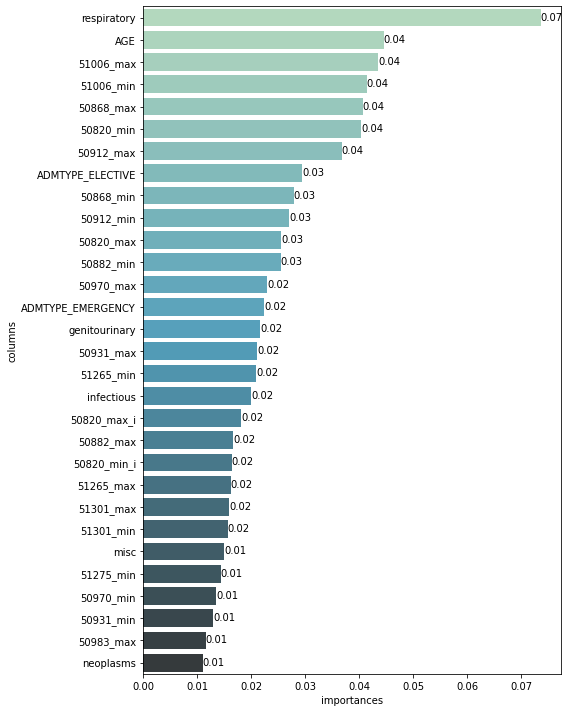

In [ ]:
fig = plt.figure(figsize=(8,10))
ax = sns.barplot(df_feat_imp_30['importances'],df_feat_imp_30['columns'], palette='GnBu_d')
ax.set_yticklabels(df_feat_imp_30['columns'], fontsize=10)

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()))
  initialx+=1

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig(path+'RF_feature_importance_top30.png')

## PermutationImportance

- Mean Decrease in Impurity (MDI)의 한계점과, 이를 보완하는 permutation importance에 대한 내용  
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

### sklearn 

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
# sklearn_perm = permutation_importance(rf, X_train, y_train, n_repeats=10,
#                                       random_state=42)

In [ ]:
features = u_dummy_pivot12_ind.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','staytime'], axis=1).columns.values
sklearn_perm_imp = pd.DataFrame({'columns':features, 'importances':sklearn_perm.importances_mean})
sklearn_perm_imp = sklearn_perm_imp.sort_values(by=['importances'], ascending=False)

In [ ]:
sklearn_perm_imp.head(30)

columns  importances
16         respiratory     0.028687
0                  AGE     0.014777
60           50820_min     0.007479
123        50820_max_i     0.006878
6        genitourinary     0.006571
7           infectious     0.006543
87           50931_max     0.005900
102        50820_min_i     0.005802
82           50868_max     0.005243
62           50882_min     0.005033
80           51301_min     0.004893
10                misc     0.004781
101          51301_max     0.004753
81           50820_max     0.004544
61           50868_min     0.004320
91           50983_max     0.003900
19   ADMTYPE_EMERGENCY     0.003900
66           50931_min     0.003565
18    ADMTYPE_ELECTIVE     0.003369
12           neoplasms     0.003369
83           50882_max     0.003327
78           51275_min     0.003285
85           50902_max     0.003048
70           50983_min     0.003006
13             nervous     0.002992
64           50902_min     0.002866
65           50912_min     0.002852
99           51275_max     0.002824
86           50912_max     0.002810
68           50970_min     0.002530

In [ ]:
fig = plt.figure(figsize=(8,10))
ax = sns.barplot(sklearn_perm_imp_30['importances'],sklearn_perm_imp_30['columns'], palette='GnBu_d')
ax.set_yticklabels(sklearn_perm_imp_30['columns'], fontsize=10)

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()))
  initialx+=1

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [ ]:
fig.savefig(path+'RF_permutation_importance_top30.png')

In [ ]:
sklearn_perm_imp_30.index

Int64Index([ 16,   0,  60, 123,   6,   7,  87, 102,  82,  62,  80,  10, 101,
             81,  61,  91,  19,  66,  18,  12,  83,  78,  85,  70,  13,  64,
             65,  99,  86,  68],
           dtype='int64')

In [ ]:
df_feat_imp_30.index

Int64Index([ 16,   0,  92,  71,  82,  60,  86,  18,  61,  65,  81,  62,  89,
             19,   6,  87,  77,   7, 123,  83, 102,  98, 101,  80,  10,  78,
             68,  66,  91,  12],
           dtype='int64')

In [ ]:
perm_idx = sklearn_perm_imp_30.index
mdi_idx = df_feat_imp_30.index
# set(sklearn_perm_imp_30.index) & set(df_feat_imp_30.index) # 교집합
# set(sklearn_perm_imp_30.index) | set(df_feat_imp_30.index) # 합집합
# set(df_feat_imp_30.index)-set(sklearn_perm_imp_30.index) # MDI only
# set(sklearn_perm_imp_30.index)-set(df_feat_imp_30.index) # Per only